# Setup

Running the simulations presumes the installation of specific packages, in particular Gammapy0.19. The easiest is maybe to simply recreate my conda environment, and run this notebook from there. Download the file env_swyft3-ext.yaml, and write the following in the terminal:

```
$conda env create --file env_swyft3-ext.yaml --name swyft3
$conda activate swyft3
```
Then download the IRF file *Prod5-North-20deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits* and *ALP_quick_sim.py*. If you place them in the same directory as this notebook, you should be set to run. Otherwise adapt the paths in the following cell:


In [47]:
import os
irf_file = os.path.dirname(os.getcwd())+"/IRFs/CTA/Prod5-North-20deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"    # The path to the IRF_file (relative to this notebook)
ALP_file_dir = os.path.dirname(os.getcwd())+"/analysis_scripts/ALP_sim"             # The directory where ALP_quick_sim.py is placed. Can be empty if it's in same folder as notebook. 

In [48]:
import sys
if ALP_file_dir: sys.path.append(ALP_file_dir)   #!!! Change path to location of differential_counts.py and ALP_sim.py
from ALP_quick_sim import ALP_sim

In [49]:
import numpy as np

In [50]:
import matplotlib.pyplot as plt

In [51]:
# import swyft.lightning as sl
import swyft

In [52]:
import torch
import torch.distributions as td

In [53]:
from joblib import Parallel, delayed

# Configuration

In [54]:
model = "toy_line"

In [55]:
n_sim = 10_000
nbins = 100

In [56]:
param_names = ['m','g','A']

priors = dict(
    m = td.Uniform(-1,1),
    g = td.Uniform(-1,1),
    A = td.Uniform(-1,1)
)

# params = {
#     'z[0]' : td.Uniform(-1,1),
#     'z[1]' : td.Uniform(-1,1),
#     'z[2]' : td.Uniform(-1,1)
# }

truth = dict(
    m = 0.09762701,
    g = 0.43037873,
    A = 0.20552675
)

# Simulation setup (see ALP_sim tutorial)

In [58]:
A = ALP_sim()

In [59]:
A.configure_obs(nbins = nbins,irf_file = irf_file)

In [60]:
A.configure_model(ALP_seed=0)

In [61]:
class Simulator(swyft.Simulator):
    def __init__(self, A, bounds = None, model = ""):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.priors = priors
        self.truth = truth
        
        use_model=None
        if model=="":
            self.use_model=A.model
        elif model=="log":
            self.use_model=A.model_log
        elif model=="spectral_fit":
            self.use_model=A.model_spectral_fit
        elif model=="spectral_fit_log":
            self.use_model=A.model_spectral_fit_log
        elif model=="toy_line":
            self.use_model=A.model_toy_line
        elif model=="toy_sine":
            self.use_model=A.model_toy_sine
        else:
            raise ValueError("Invalid model specified")

        self.noise = A.noise
        self.nbins = A.nbins
        
    def sample_prior(self,):
        param_sample = [np.array(self.priors[key].sample()) for key in self.priors.keys()]
        #return torch.tensor(param_sample)
        return np.array(param_sample)
    
    def generate_observation(self,):
        vec = [self.truth[key] for key in self.truth.keys()]
        xs = np.linspace(-1,1,self.nbins)
        observation = dict(data = np.ones_like(xs)*vec[0] + xs*vec[1] + xs**2*vec[2] + np.random.randn(nbins)*0.2) 
        return observation

    def generate_exp(self,vec):
        #vec = np.array(self.sample_prior())
        #y = self.use_model(np.array(vec))
        xs = np.linspace(-1,1,self.nbins)
        y = np.ones_like(xs)*vec[2] + xs*vec[1] + xs**2*vec[0]
        return y

    # def generate_data(self):
    #     y = {'y':self.generate_exp()}
    #     data = self.noise(y, None)
    #     return data['y']

    def generate_data(self,exp):
        # y = self.generate_exp()
        data = exp + np.random.randn(nbins)*0.2
        return data

    def build(self, graph):
        params = graph.node('params', self.sample_prior)
        exp = graph.node('exp', self.generate_exp, params)
        data = graph.node('data', self.generate_data, exp)
        

In [62]:
sim = Simulator(A, model=model)

In [63]:
samples = sim.sample(n_sim, targets=['data', 'params'])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [64]:
#samples

In [65]:
#samples

In [66]:
observation = sim.generate_observation()
observation = swyft.Sample(observation)

In [67]:
#observation

In [68]:
# for i in range(min(len(samples),100)):
#     plt.plot(samples[i]['data'])
# plt.plot(observation['data'], color='r')

In [69]:
# torch.manual_seed(0)
# np.random.seed(0)
# N = 10_000  # Number of samples
# Nbins = 100
# z = np.random.rand(N, 3)*2 - 1
# y = np.linspace(-1, 1, Nbins)
# m = np.ones_like(y)*z[:,:1] + y*z[:,1:2] + y**2*z[:,2:]
# x = m + np.random.randn(N, Nbins)*0.2

# # We keep the first sample as observation, and use the rest for training
# samples = swyft.Samples(data = x[1:], params = z[1:])
# observation = swyft.Sample(data = x[0], params = z[0])

In [70]:
# class SimpleDenseResidualBlock(torch.nn.Sequential):
#     def __init__(self, in_channels, growth_rate):
#         super(SimpleDenseResidualBlock, self).__init__(
#             torch.nn.Conv1d(in_channels, growth_rate, kernel_size=1, padding=1),
#             torch.nn.BatchNorm1d(growth_rate),
#             torch.nn.ReLU(inplace=True),
#             torch.nn.Conv1d(growth_rate, in_channels, kernel_size=1, padding=1),
#             torch.nn.BatchNorm1d(in_channels)
#         )
 
#     def forward(self, x):
#         out = super(SimpleDenseResidualBlock, self).forward(x)
#         out = x + out  # Residual connection
#         return out

In [71]:
# class Network(sl.SwyftModule):
#     def __init__(self):
#         super().__init__()
#         self.CNN = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=4)
#         self.flatten = torch.nn.Flatten(1)
#         self.compress = torch.nn.LazyLinear(32)
#         self.logratios_1d = sl.LogRatioEstimator_1dim(num_features=32,
#                                                      num_params=2,
#                                                      hidden_features=16,
#                                                      dropout=0.2,
#                                                      varnames = 'params')

#     def forward(self, A, B):
#         data = self.CNN(A['data'].unsqueeze(1))
#         data = self.flatten(data)
#         data = self.compress(data)
#         params = B['params']
#         logratios = self.logratios_1d(data, params)
#         return logratios

In [72]:
samples['data'].shape

(10000, 100)

In [73]:
samples['params'].shape

(10000, 3)

In [74]:
samples

Samples({'params': array([[ 0.8878411 ,  0.7714342 , -0.9581746 ],
       [ 0.85169435, -0.18541515, -0.9065385 ],
       [-0.27785707,  0.64982665, -0.0212605 ],
       ...,
       [-0.35550213,  0.03108597,  0.60794985],
       [ 0.04732108,  0.19425046, -0.8297267 ],
       [ 0.7526083 , -0.0197984 , -0.15692174]], dtype=float32), 'exp': array([[-0.84176767, -0.86169314, -0.88089395, ...,  0.5996363 ,
         0.6500062 ,  0.7011007 ],
       [ 0.13057101,  0.09276095,  0.05564608, ..., -0.30020118,
        -0.27057782, -0.24025929],
       [-0.9489442 , -0.92470324, -0.90068907, ...,  0.34645295,
         0.3486944 ,  0.35070908],
       ...,
       [ 0.22136176,  0.2362084 ,  0.25076485, ...,  0.31042477,
         0.29712433,  0.2835337 ],
       [-0.9766561 , -0.97462445, -0.97255427, ..., -0.59975034,
        -0.593972  , -0.58815515],
       [ 0.61548495,  0.5849837 ,  0.5550968 , ...,  0.51709986,
         0.54618686,  0.57588816]], dtype=float32), 'data': array([[-0.7825351 ,

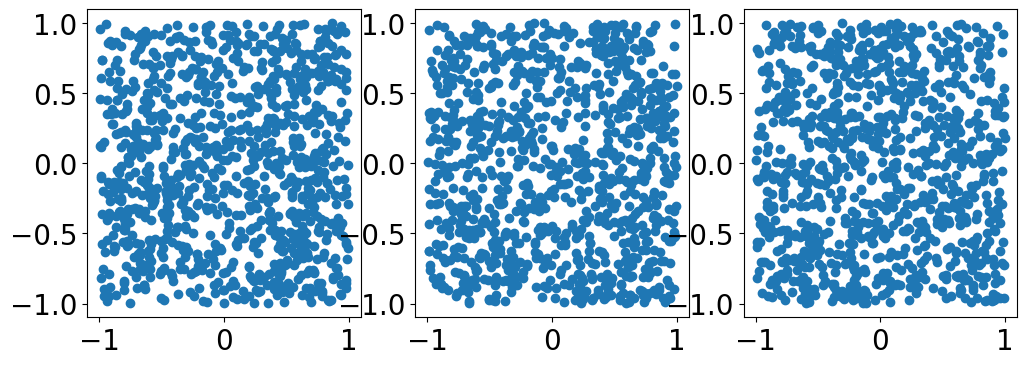

In [85]:
plt.figure(figsize=(12,4))
for i, pair in enumerate([[0,1],[0,2],[1,2]]):
    plt.subplot(1,3,i+1)
    plt.scatter(samples['params'][:1000,pair[0]],samples['params'][:1000,pair[1]])

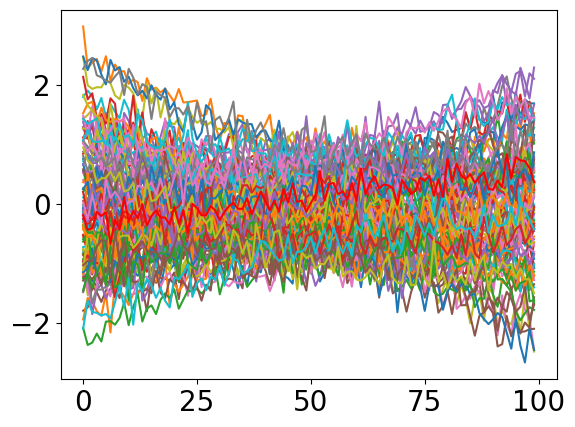

In [87]:
for i in range(min(len(samples),100)):
    plt.plot(samples[i]['data'])
plt.plot(observation['data'], color='r')

In [33]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features = A.nbins, 
            num_params = len(param_names), 
            varnames = param_names)
#        self.learning_rate = 0.0005
    

        
    def forward(self, A, B):
        return self.logratios(A['data'], B['params'])

In [34]:
network = Network()

In [35]:
trainer = swyft.SwyftTrainer(
    accelerator = 'cpu', precision = 64 #, min_epochs =25, 
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [36]:
dm = swyft.SwyftDataModule(samples)

In [37]:
trainer.fit(network, dm)

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 71.2 K
-----------------------------------------------------
71.2 K    Trainable params
0         Non-trainable params
71.2 K    Total params
0.570     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /home/gert/ALPs_with_SWYFT/notebooks/lightning_logs/version_2/checkpoints/epoch=18-step=4750.ckpt


In [38]:
prior_samples = sim.sample(100_000, targets=['params'])

  0%|          | 0/100000 [00:00<?, ?it/s]

In [39]:
logratios = trainer.infer(
                        network,
                        observation,
                        prior_samples
                        )

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [40]:
observation

Sample({'data': array([-0.34377447, -0.03387469,  0.11107055, -0.16900375, -0.1680975 ,
       -0.08564537,  0.2868832 , -0.08099325, -0.36811199, -0.21947143,
        0.00714601, -0.31864224, -0.23501802, -0.31691998, -0.1570684 ,
        0.06589362, -0.23283725, -0.32945907, -0.01413   ,  0.15020653,
        0.0559101 , -0.2883906 , -0.13893064, -0.08837549,  0.11091249,
       -0.2459237 ,  0.15530839, -0.19028877,  0.50417369, -0.06279432,
        0.24360436, -0.1660715 ,  0.04415621, -0.18032274, -0.01480703,
       -0.12630316, -0.22079748,  0.23833047,  0.07042294, -0.08433723,
       -0.00172846,  0.09169327,  0.24576492,  0.29729806,  0.09062   ,
        0.04470522,  0.04375049,  0.13301148, -0.1250794 ,  0.36577842,
       -0.177696  ,  0.15605102, -0.18284673,  0.26263412,  0.05051288,
        0.24696227,  0.14406223,  0.19084339,  0.20976233,  0.22462384,
        0.13281851,  0.18427087, -0.23502552,  0.3033625 ,  0.05866461,
        0.89108309, -0.06336511,  0.35425684,  0

In [41]:
prior_samples

Samples({'params': array([[-0.83729947,  0.6390444 , -0.526057  ],
       [ 0.19558394, -0.72596407, -0.37082446],
       [ 0.22064173, -0.7679591 ,  0.77284324],
       ...,
       [ 0.697291  , -0.9638572 ,  0.41641748],
       [-0.5038693 , -0.22930181,  0.88513577],
       [ 0.30557227,  0.11116624, -0.2144134 ]], dtype=float32)})

In [42]:
logratios.params.shape

torch.Size([100000, 3, 1])

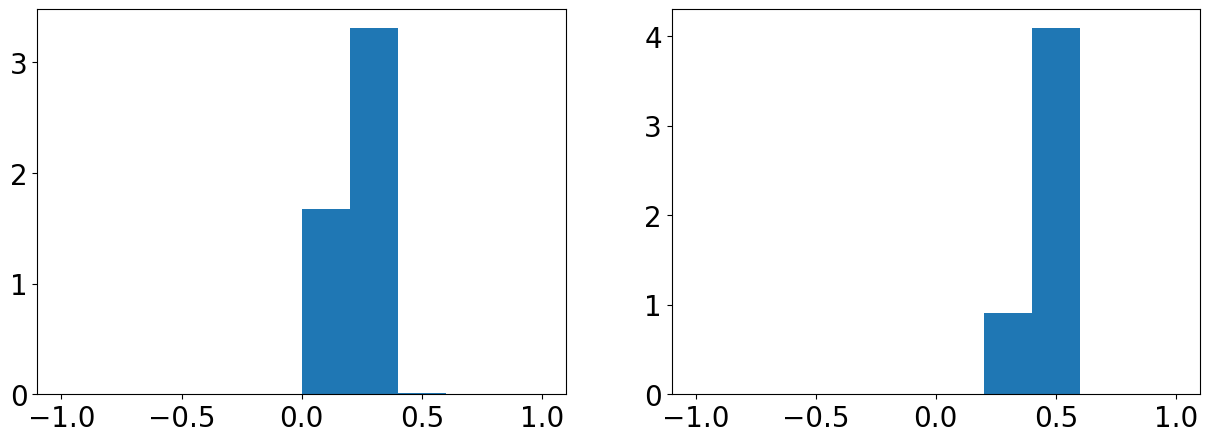

In [43]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
for i in range(2):
    axs[i].hist(
        logratios.params[:,i,0],
        density=True,
        weights=np.exp(logratios.logratios[:,i])
    )

In [44]:
truth

{'m': 0.09762701, 'g': 0.43037873, 'A': 0.20552675}

In [45]:
logratios

LogRatioSamples(logratios=tensor([[-23.1700,  -6.4193, -18.5432],
        [  1.9347, -23.7799, -16.9945],
        [  2.0685, -24.3950, -17.9708],
        ...,
        [ -9.7833, -27.2831, -14.8527],
        [-16.3874, -16.6078, -18.7571],
        [  1.0212, -10.7661, -15.0165]], dtype=torch.float64), params=tensor([[[-0.8373],
         [ 0.6390],
         [-0.5261]],

        [[ 0.1956],
         [-0.7260],
         [-0.3708]],

        [[ 0.2206],
         [-0.7680],
         [ 0.7728]],

        ...,

        [[ 0.6973],
         [-0.9639],
         [ 0.4164]],

        [[-0.5039],
         [-0.2293],
         [ 0.8851]],

        [[ 0.3056],
         [ 0.1112],
         [-0.2144]]], dtype=torch.float64), parnames=array([['m'],
       ['g'],
       ['A']], dtype='<U1'), metadata={})

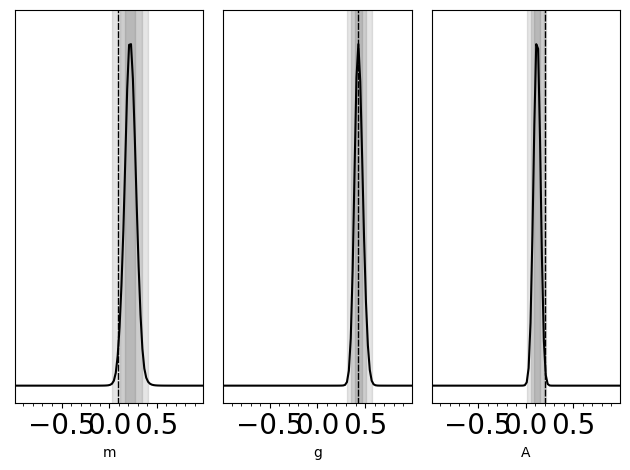

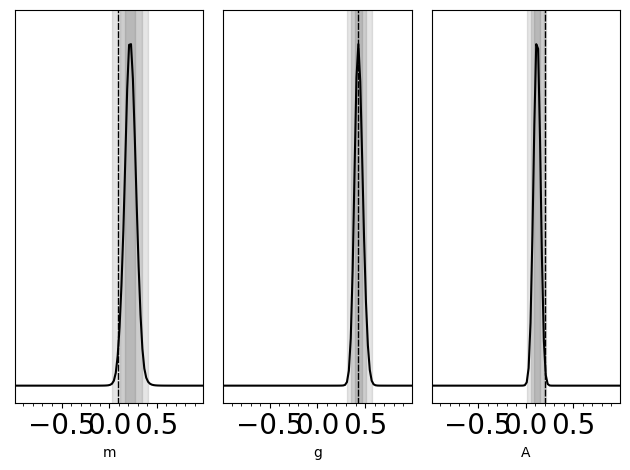

In [46]:
swyft.plot_posterior(logratios, list(truth.keys()), truth=truth)